# Braiding for Kapit-Mueller Model with First Band Approximation

In [132]:
using QuantumOptics
using NBInclude
using SparseArrays
using DataFrames
using Plots
using Interpolations
using LinearAlgebra
using LaTeXStrings
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));
@nbinclude(joinpath("../Hofstadter","Torus_Distance.ipynb"));
@nbinclude(joinpath("../Braiding Utils.ipynb"));

In [142]:
Nx = 5
Ny = 5
p = 12
q = 25
pn = 5
N_Pin = 2
U = 1

N_Site = Nx*Ny
t = 1
NPhi0 = Int(Nx*Ny*(p/q))
Cut_Off = NPhi0
PN = vcat( ( [i] for i in 0:pn) ... )

nu0 = 1/2 # The quasihole numbers depend on Laughlin fraction
NPhi = NPhi0-N_Pin
N_d = Int(NPhi - pn/nu0)
nu = pn//NPhi0
Degeneracy = Int((factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * (NPhi / pn))
println("Lattice: ",Nx,"x",Ny,
        "\nThe Number of Flux per Unit-Cell (p/q) = ",p//q,
        "\nFilling Fraction = ",nu," (The Number of Quasiholes = ",(N_Pin+N_d),
        ")\nThe Number of Flux Quanta = ", NPhi,
        " (Delocalised Number = ", N_d,
        ")\nThe Total Number of Particle = ",pn,
        "\nThe Number of State of Ground Degeneracy = ",Degeneracy)

Lattice: 5x5
The Number of Flux per Unit-Cell (p/q) = 12//25
Filling Fraction = 5//12 (The Number of Quasiholes = 2)
The Number of Flux Quanta = 10 (Delocalised Number = 0)
The Total Number of Particle = 5
The Number of State of Ground Degeneracy = 2


In [143]:
function KM(Nx, Ny, t, p, q)
    coordinates = vcat( ( [y x] for x in 0:Nx-1 for y in 0:Ny-1 ) ... )
    alpha = p/q
    H = spzeros(Complex{Float64}, N_Site, N_Site)
    for j in 1:N_Site
        for k in 1:N_Site
            if j!=k
                x_j = coordinates[j, 1] 
                y_j = coordinates[j, 2] 
                x_k = coordinates[k, 1]
                y_k = coordinates[k, 2]
                z_j = x_j + 1im*y_j
                z_k = x_k + 1im*y_k
                for n in range(-1,1)
                    for m in range(-1,1)
                        R = n * Nx + 1im * m * Ny
                        z = (z_k - z_j) + R 
                        G = (-1) ^ ( real(z) + imag(z) + real(z) * imag(z) )
                        beta = (pi/2) * ( (z_j * conj(z) ) - (conj(z_j) * z) )*alpha
                        W = t * G * exp( -pi/2 * (1-alpha) * (abs(z)^2) )
                        J = W * exp(beta) * exp( pi/2 * ( (z_j * conj(R) ) - (conj(z_j) * R) ) * alpha)
                        H[j,k] += J
                    end
                end
            end
        end
    end
    return H
end

KM (generic function with 1 method)

In [144]:
Sp_Basis = NLevelBasis(N_Site);

In [145]:
function Sp_Sub(N_Site, Nx, Ny, t, p, q, Sp_Basis, Cut_Off)
    Sp = KM(Nx, Ny, t, p, q)
    H_Sp = get_sp_op(Sp_Basis, Sp)
    H_Sp = dense((H_Sp+H_Sp')/2)
    Sub_States = get_sub_states(H_Sp, Cut_Off)
    Sub_Basis, P, Pt = get_projector_op(Sub_States, Sp_Basis)
    H_Sp_Sub = get_subspace_op(H_Sp, P, Pt)
    return H_Sp, Sub_Basis, P, Pt, H_Sp_Sub
end

Sp_Sub (generic function with 1 method)

In [146]:
H_Sp, Sub_Basis, P, Pt, H_Sp_Sub = Sp_Sub(N_Site, Nx, Ny, t, p, q, Sp_Basis, Cut_Off);
EEA, UUA = eigenstates(H_Sp);

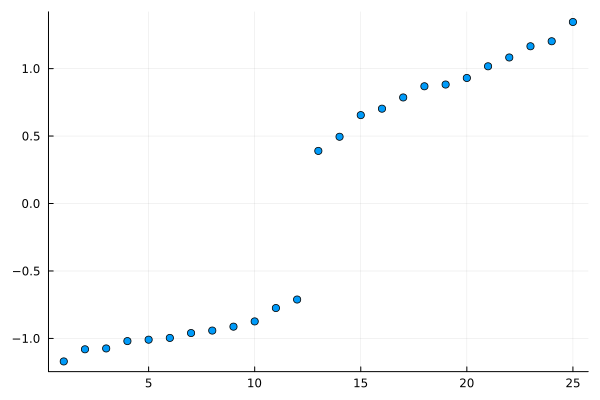

In [147]:
scatter(EEA,legend=false)

In [114]:
Sub_Number_Operator_List = get_num_sub_list(N_Site, Sp_Basis, P, Pt);

In [115]:
function get_MB_Sub(Sub_Basis, PN, H_Sp_Sub)
    MB_States = bosonstates(Sub_Basis, PN) 
    MB_Basis = ManyBodyBasis(Sub_Basis, MB_States)
    H_MB_Sub = get_mb_op(MB_Basis, H_Sp_Sub)
    return H_MB_Sub
end

get_MB_Sub (generic function with 1 method)

In [116]:
H_MB_Sub = get_MB_Sub(Sub_Basis, PN, H_Sp_Sub);

In [117]:
function get_Bosonic_MB_Basis(N_Site, PN)
    N_Basis = NLevelBasis(N_Site)
    N_States = bosonstates(N_Basis, PN)
    N_Basis_MB = ManyBodyBasis(N_Basis, N_States)
    return N_Basis_MB, N_Basis
end

get_Bosonic_MB_Basis (generic function with 1 method)

In [118]:
Basis_Cut_MB, Basis_Cut_Sp = get_Bosonic_MB_Basis(Cut_Off, PN)

(ManyBody(onebodybasis=NLevel(N=9), states:715), NLevel(N=9))

In [119]:
H_Kin = SparseOperator(Basis_Cut_MB)
H_Kin.data = H_MB_Sub.data;

In [120]:
H_Int = Hubbard_Interaction(P, Pt, Basis_Cut_MB, Cut_Off, U);

In [121]:
Sub_Number_MB_Operator_List = get_num_mb_op(N_Site, Basis_Cut_Sp, Sub_Number_Operator_List, Basis_Cut_MB, Sub_Basis);

In [122]:
Total_H = H_Kin + H_Int;

# Impurity

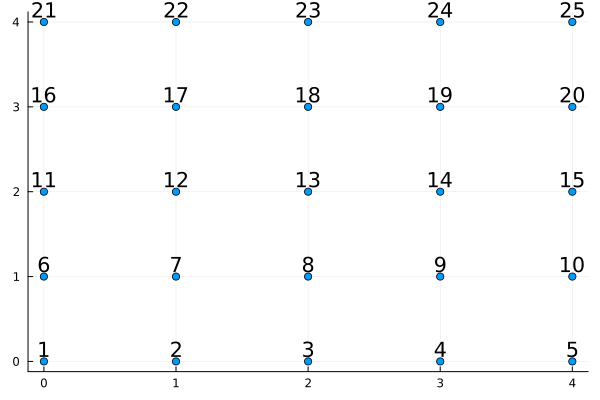

In [123]:
co = vcat( ( [y x] for x in 0:Nx-1 for y in 0:Ny-1 ) ... )
scatter(co[:,1],co[:,2], series_annotations = text.([i for i in 1:N_Site], :bottom), legend=false)

In [124]:
V0 = [4, 0]; Imp_Site = [21, 9]
Impurity_Data = Impurity(V0, Imp_Site)

Impurity([4.0, 0.0], [21, 9])

In [125]:
Impurity_H = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [126]:
E_Imp, U_Imp = eigenstates(Impurity_H)
E_Imp;

# Filter

In [127]:
function Get_Filtered_Energies(Basis_Cut_MB, E_Imp, U_Imp, pn)
    Filtered_Energies = Array{Float64}(undef, length(E_Imp), 2)
    for i in 1:length(E_Imp)
        Filtered_Energies[i] = round(expect(number(Basis_Cut_MB), U_Imp[i])) 
        Filtered_Energies[i,2] = E_Imp[i] 
    end
    df = DataFrame(Filtered_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    return Matrix(df)[:,2]
end

Get_Filtered_Energies (generic function with 1 method)

In [128]:
Fil_Energies = Get_Filtered_Energies(Basis_Cut_MB, E_Imp, U_Imp, pn)
Fil_Energies;

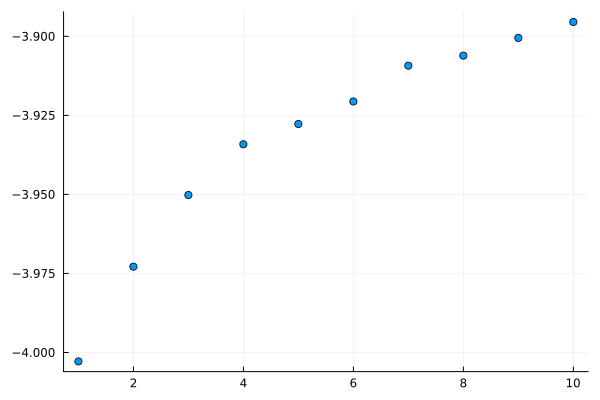

In [129]:
scatter(Fil_Energies[1:10], label=false)

In [130]:
function Get_Filtered_States(Fil_Energies, U_Imp)
    number_of_states = length(Fil_Energies)
    return U_Imp[1:number_of_states]
end

Get_Filtered_States (generic function with 1 method)

In [131]:
Fil_States = Get_Filtered_States(Fil_Energies, U_Imp);

# Density

In [97]:
function Get_Density_Profile(N_Site,Sub_Number_MB_Operator_List,Basis_Cut_MB,Fil_States,index)
    Expectation_List = []
    for site in 1:N_Site
        push!(Expectation_List, expect(Sub_Number_MB_Operator_List[site], Fil_States[index]))
    end
    return real(Expectation_List)
end

Get_Density_Profile (generic function with 1 method)

In [98]:
function Get_Avg_Density(Nx, Ny, Degeneracy, N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, Fil_States)
    Avg_Density = spzeros(Nx,Ny)
    for index in 1:Degeneracy
        Avg_Density += reshape(Get_Density_Profile(N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, Fil_States, index), Nx, Ny)
    end    
    return Avg_Density / Degeneracy
end

Get_Avg_Density (generic function with 1 method)

In [99]:
function Interp(data, factor)
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)
    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)
    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end
    return finery, finerx, data_interp
end

Interp (generic function with 1 method)

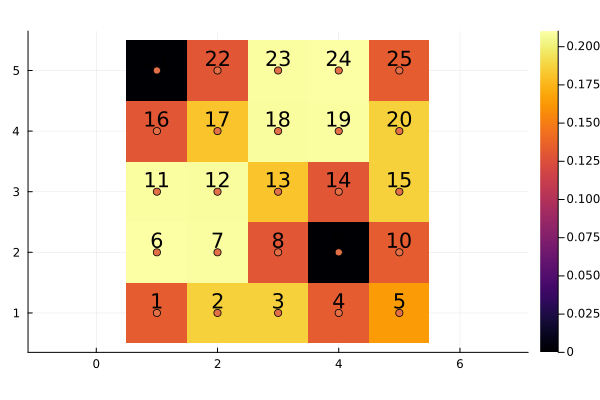

In [100]:
data = Get_Avg_Density(Nx, Ny, Degeneracy, N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, Fil_States)'
factor = 1
Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)
scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N_Site], :bottom), legend=false)

In [101]:
Total_Particle_Number = sum(Get_Avg_Density(Nx, Ny, Degeneracy, N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, Fil_States))

3.9999999999999996

# Moving Quasiholes

In [102]:
start_point = Impurity_Data.Imp_Site[1]
lens = [3, 3]
dirs = [1,-Ny]
rec_path_1 = rectangular_path(start_point,lens,dirs)
rec_path_1 = unique(rec_path_1)

7-element Vector{Int64}:
 21
 22
 23
 24
 19
 14
  9

In [103]:
start_point = Impurity_Data.Imp_Site[2]
lens = [3, 3]
dirs = [-1,Ny]
rec_path_2 = rectangular_path(start_point,lens,dirs)
rec_path_2 = unique(rec_path_2)

7-element Vector{Int64}:
  9
  8
  7
  6
 11
 16
 21

# Berry Matrix

In [104]:
N_Pin = 4
V1 = Impurity_Data.V0[1]
V2 = Impurity_Data.V0[2]
delta_t = 0.025

0.025

In [105]:
BerryMatrix = Berry_Matrix(rec_path_1, rec_path_2, Degeneracy, delta_t)
BerryEnergies, BerryStates = eigen(BerryMatrix)
BerryEnergies

2-element Vector{ComplexF64}:
 -0.9580895292569048 + 0.2864689405996428im
 -0.4658950408877655 + 0.8848399916799565im

In [106]:
angle.(BerryEnergies)/pi

2-element Vector{Float64}:
 0.9075184763983609
 0.6542675719369345

# Simulation

In [41]:
movie(delta_t, 50, Nx, Ny, Degeneracy, N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, co)

!Nx and Ny must be equalt to each other!


[ Info: Saved animation to C:\Users\Can\Downloads\Git File\Kagome-Lattice\My Numerical Calculations\Many-Body\Kapit-Mueller\tmp.gif


# Charge Depletion Profile

In [271]:
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(co)
ref_coordinates = co
ref_site = 7
radius_list = get_radii(ref_coordinates, co, ref_site, N_Site);
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny, co);

In [272]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = co # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

In [273]:
ref_den = pn/(Nx*Ny)

0.1875

In [274]:
function get_depletion_profile(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((ref_den .- avg_density')))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile (generic function with 1 method)

In [275]:
depletion_prof = get_depletion_profile(radius_list, data)

6-element Vector{Any}:
 0.18749999999999914
 0.2955841276506699
 0.22296487418979105
 0.15250642939177894
 0.028146383684182374
 2.7755575615628914e-17

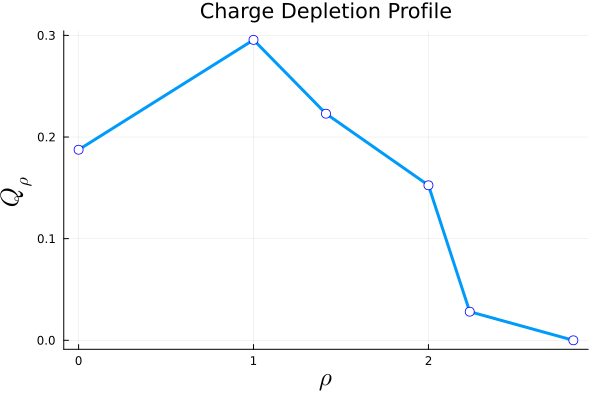

In [276]:
Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Charge Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))